In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
firsTime=datetime.datetime.now()
print(firsTime)
torch.manual_seed(190401068)
batch_size = 16

2023-04-10 18:57:29.603485


In [4]:
# Veri setlerini yükleme
train_df = pd.read_csv('/content/drive/MyDrive/yapay_sinir_aglari/cure_the_princess_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/yapay_sinir_aglari/cure_the_princess_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/yapay_sinir_aglari/cure_the_princess_validation.csv')

from torch.utils.data import DataLoader, TensorDataset
train_inputs = train_df.drop('Cured', axis=1).values
train_labels = train_df['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = val_df.drop('Cured', axis=1).values
val_labels = val_df['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = test_df.drop('Cured', axis=1).values
test_labels = test_df['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [5]:
# Modeli oluşturma
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
       
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [6]:
input_size=len(train_df.columns) - 1
hidden_size1=100
hidden_size2=50
output_size=2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Farklı bir model adıyla oluşturdumki çalışıyormu görebileyim
model = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

In [7]:

# loss fonksiyonu belirlenir
#criterion = nn.BCELoss()
criterion=nn.CrossEntropyLoss()
#Optimizasyon için Stochastic Gradient Descent yöntemini seçilir
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# Epoch sayısı ve learning rate değerlerini belirlenir
num_epochs = 50
# Batch size seçilir

In [8]:
def early_stopping(model, val_score, best_val_loss, patience,patience_counter):
    stop_training = False
    if best_val_loss is None:
        patience_counter = 0
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score:
        patience_counter += 1
        print("Earlystopping Patience Counter", patience_counter)
        if patience_counter == patience:
             stop_training = True
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt")
        patience_counter = 0

    return best_val_loss, patience_counter, stop_training


In [9]:
train_loss_list=[]
best_val_loss=None
patience=5
val_loss_list=[]
patience_counter = 0
#stop_training = False
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #l1
        l1_lambda = 0.001
        l1_reg = torch.tensor(0.)
        for param in model.parameters():
            l1_reg += torch.norm(param, p=1)
        loss += l1_lambda * l1_reg
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_acc = 100 * correct / total
    # Değerlendirme modu
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            #l1
            l1_lambda = 0.001
            l1_reg = torch.tensor(0.)
            for param in model.parameters():
              l1_reg += torch.norm(param, p=1)
            loss += l1_lambda * l1_reg
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * (correct / total)
    val_loss_list.append(val_loss)
    #EarlyStopping
    val_score=val_loss
    best_val_loss, patience_counter, stop_training=early_stopping(model,val_score,best_val_loss,patience,patience_counter)
    if stop_training==True:
      break
    print(f'Epoch: {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')

Epoch: 1/50 - Train Loss: 1.0929 - Train Acc: 67.09% - Val Loss: 1.0392 - Val Acc: 75.48%
Epoch: 2/50 - Train Loss: 1.0308 - Train Acc: 75.24% - Val Loss: 0.9780 - Val Acc: 82.17%
Earlystopping Patience Counter 1
Epoch: 3/50 - Train Loss: 0.9832 - Train Acc: 79.07% - Val Loss: 0.9826 - Val Acc: 76.75%
Epoch: 4/50 - Train Loss: 0.9528 - Train Acc: 81.55% - Val Loss: 0.9330 - Val Acc: 81.53%
Epoch: 5/50 - Train Loss: 0.9213 - Train Acc: 84.66% - Val Loss: 0.8785 - Val Acc: 91.72%
Epoch: 6/50 - Train Loss: 0.9012 - Train Acc: 86.02% - Val Loss: 0.8614 - Val Acc: 90.13%
Epoch: 7/50 - Train Loss: 0.8879 - Train Acc: 86.50% - Val Loss: 0.8429 - Val Acc: 92.68%
Epoch: 8/50 - Train Loss: 0.8726 - Train Acc: 87.70% - Val Loss: 0.8358 - Val Acc: 91.08%
Earlystopping Patience Counter 1
Epoch: 9/50 - Train Loss: 0.8628 - Train Acc: 88.42% - Val Loss: 0.8422 - Val Acc: 90.45%
Epoch: 10/50 - Train Loss: 0.8512 - Train Acc: 88.50% - Val Loss: 0.8129 - Val Acc: 92.68%
Epoch: 11/50 - Train Loss: 0.8429

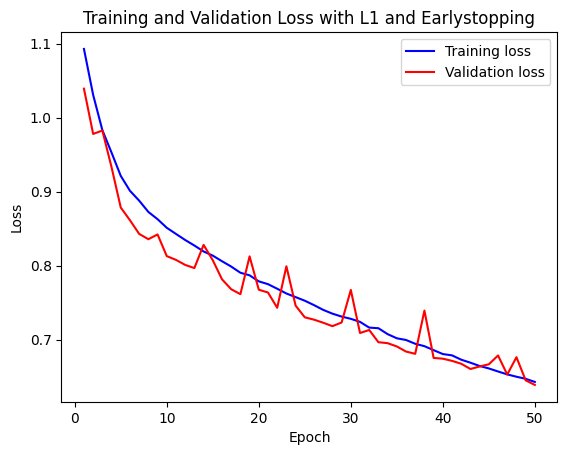

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.plot(epochs, val_loss_list, 'r', label='Validation loss')
plt.title('Training and Validation Loss with L1 and Earlystopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
input_size=len(train_df.columns) - 1
hidden_size1=100
hidden_size2=50
output_size=2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Farklı bir model adıyla oluşturdumki çalışıyormu görebileyim
model2 = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

In [12]:
model2.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [13]:
from sklearn.metrics import confusion_matrix

# Modeli değerlendirme modunda ayarla
model.eval()
# Test seti üzerinde döngüye gir ve tahminler yap
with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()

# Confusion matrix'i hesapla
cm = confusion_matrix(true_labels, predicted_labels)

# Accuracy, precision, recall ve F1 skorlarını hesapla
accuracy = (cm.diagonal().sum()) / (cm.sum())
precision = (cm.diagonal() / cm.sum(axis=0)).mean()
recall = (cm.diagonal() / cm.sum(axis=1)).mean()
f1 = 2 * (precision * recall) / (precision + recall)
print("L1 ve earlystopping sonrası")
print(f"Test Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

L1 ve earlystopping sonrası
Test Accuracy : 0.9456
Precision: 0.9481
Recall: 0.9458
F1 Score: 0.9470
